In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
def save_regression_model(name: str, model: linear_model.LinearRegression, score):

    json_model_path = f'{name}.json'

    with open(json_model_path, 'w') as f:
        json.dump({
            'coefficients': list(model.coef_),
            'independent_var_names': ['income'],
            'intercept': model.intercept_,
            'score': score,
        }, f)

In [3]:
df = pd.read_csv("obesity_and_nutrition.csv")
df.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Datasource',
       'Class', 'Topic', 'Question', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol',
       'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit ',
       'Sample_Size', 'Total', 'Age(years)', 'Education', 'Gender', 'Income',
       'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'LocationID', 'StratificationCategory1',
       'Stratification1', 'StratificationCategoryId1', 'StratificationID1'],
      dtype='object')

Data is already aggregated by various categories

In [4]:
stratifications = df[['StratificationCategory1', 'Stratification1']].groupby(['StratificationCategory1', 'Stratification1']).count()
stratifications

Empty DataFrame
Columns: []
Index: [(Age (years), 18 - 24), (Age (years), 25 - 34), (Age (years), 35 - 44), (Age (years), 45 - 54), (Age (years), 55 - 64), (Age (years), 65 or older), (Education, College graduate), (Education, High school graduate), (Education, Less than high school), (Education, Some college or technical school), (Gender, Female), (Gender, Male), (Income, $15,000 - $24,999), (Income, $25,000 - $34,999), (Income, $35,000 - $49,999), (Income, $50,000 - $74,999), (Income, $75,000 or greater), (Income, Data not reported), (Income, Less than $15,000), (Race/Ethnicity, 2 or more races), (Race/Ethnicity, American Indian/Alaska Native), (Race/Ethnicity, Asian), (Race/Ethnicity, Hawaiian/Pacific Islander), (Race/Ethnicity, Hispanic), (Race/Ethnicity, Non-Hispanic Black), (Race/Ethnicity, Non-Hispanic White), (Race/Ethnicity, Other), (Total, Total)]

In [5]:
available_questions = df['Question'].unique()
available_questions

array(['Percent of adults aged 18 years and older who have obesity',
       'Percent of adults aged 18 years and older who have an overweight classification',
       'Percent of adults who report consuming fruit less than one time daily',
       'Percent of adults who report consuming vegetables less than one time daily',
       'Percent of adults who engage in muscle-strengthening activities on 2 or more days a week',
       'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)',
       'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week',
       'Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity 

### Question: What is the relationship between income and vegetable consumption?

Grab applicable data

In [6]:
filter = (
    (df['Question'] == 'Percent of adults who report consuming vegetables less than one time daily') & 
    (df['StratificationCategory1'] == 'Income') &
    (df['Stratification1'] != 'Data not reported')
)

vegetables_by_income = df[['Data_Value', 'Question', 'StratificationCategory1', 'Stratification1']].loc[filter].drop(['StratificationCategory1', 'Question'], axis=1)
vegetables_by_income.columns = ['value', 'income_range']
vegetables_by_income

,value,income_range
97,35.5,"Less than $15,000"
98,27.7,"$15,000 - $24,999"
99,29.4,"$25,000 - $34,999"
100,19.7,"$35,000 - $49,999"
101,19.9,"$50,000 - $74,999"
...,...,...
38194,16.9,"$35,000 - $49,999"
38195,20.5,"$15,000 - $24,999"
38196,23.2,"$50,000 - $74,999"
38197,24.5,"$25,000 - $34,999"


Inspect data

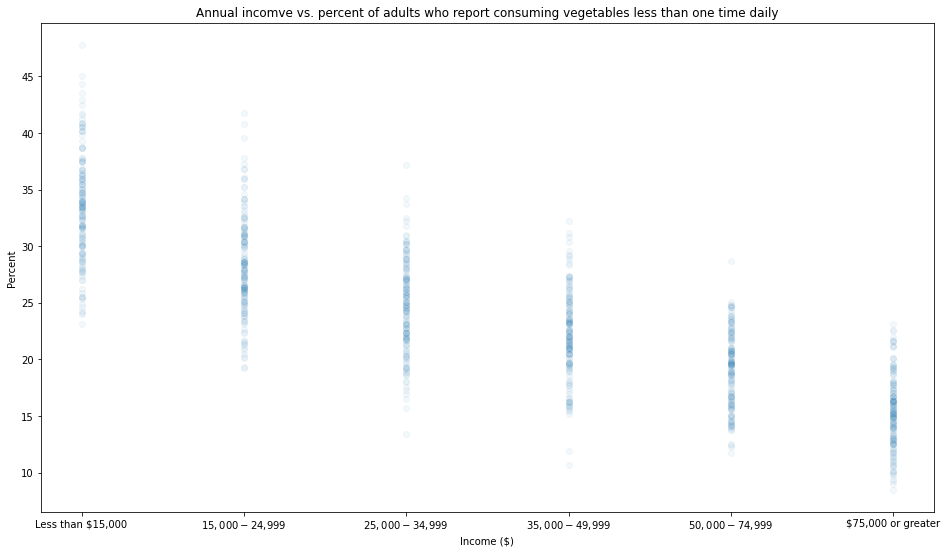

In [7]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(vegetables_by_income['income_range'], vegetables_by_income['value'], alpha=0.05)
ax.set_title('Annual incomve vs. percent of adults who report consuming vegetables less than one time daily')
ax.set_ylabel('Percent')
ax.set_xlabel('Income ($)')
plt.show()

Convert categories to number values

In [8]:
income_alias = {
    'Less than $15,000': 7500,
    '$15,000 - $24,999': 20000,
    '$25,000 - $34,999': 30000,
    '$35,000 - $49,999': 40000,
    '$50,000 - $74,999': 62500,
    '$75,000 or greater': 90000,
}

vegetables_by_income['income_val'] = vegetables_by_income.apply(lambda row: income_alias[row['income_range']], axis=1)

Build model

In [9]:
reg = linear_model.LinearRegression()
income = vegetables_by_income['income_val'].values.reshape(-1,1) # each data point presented as a list of features. In this case, only 1 feature per data point
reg.fit(income, vegetables_by_income['value'])
r_score = reg.score(income, vegetables_by_income['value'])
print(f'Coefficients: {reg.coef_}')
print(f'Intercept: {round(reg.intercept_, 2)}')
print(f'R2 score {r_score}')

save_regression_model('simple_linear_regressions', reg, r_score) 

Coefficients: [-0.00020652]
Intercept: 32.44
R2 score 0.6433329137979844


Create prediction set and plot against training set

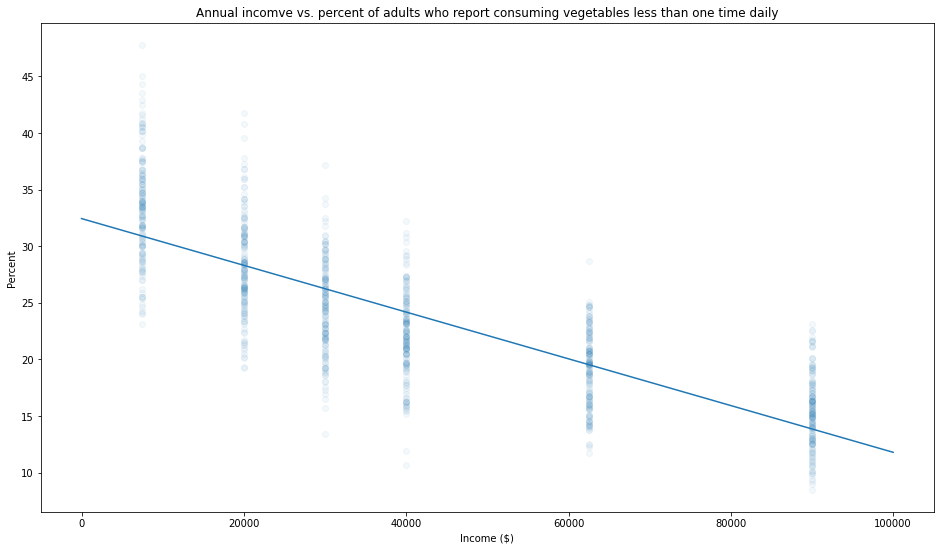

In [10]:
income_test = np.linspace(0, 100000).reshape(-1, 1)
predictions = reg.predict(income_test)

fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(vegetables_by_income['income_val'], vegetables_by_income['value'], alpha=0.05)
ax.plot(income_test, predictions)
ax.set_title('Annual incomve vs. percent of adults who report consuming vegetables less than one time daily')
ax.set_ylabel('Percent')
ax.set_xlabel('Income ($)')
plt.show()

Save model values for use in web app

In [11]:


MODEL_NAME = 'simple_linear_regressions'

json_model_path = f'{MODEL_NAME}.json'
data_csv_path = f'{MODEL_NAME}_data.csv'

with open(json_model_path, 'w') as f:
    json.dump({
        'coefficients': list(reg.coef_),
        'independent_var_names': ['income'],
        'intercept': reg.intercept_,
        'score': r_score,
    }, f)

vegetables_by_income.to_csv(data_csv_path)

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

x = vegetables_by_income['income_val'].values.reshape(-1,1)
linear = linear_model.LinearRegression()

poly = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), linear)

poly.fit(x, vegetables_by_income['value'])
poly_r_score = poly.score(x, vegetables_by_income['value'])
print(f'Coefficients: {linear.coef_}')
print(f'Intercept: {round(linear.intercept_, 2)}')
print(f'R2 score {poly_r_score}')

save_regression_model("poly_linear_regression", linear, poly_r_score)

Coefficients: [-4.24935541e-04  2.21066506e-09]
Intercept: 36.03
R2 score 0.6873740845123167


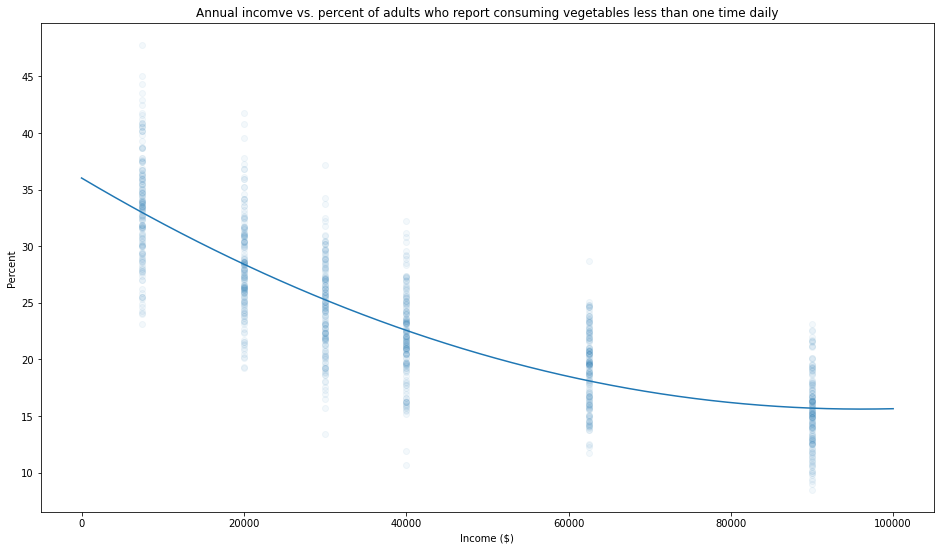

In [13]:
poly_test_income = np.linspace(0, 100000).reshape(-1, 1)
poly_predictions = poly.predict(poly_test_income)

fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(vegetables_by_income['income_val'], vegetables_by_income['value'], alpha=0.05)
ax.plot(poly_test_income, poly_predictions)
ax.set_title('Annual incomve vs. percent of adults who report consuming vegetables less than one time daily')
ax.set_ylabel('Percent')
ax.set_xlabel('Income ($)')
plt.show()